In [1]:
from models import Actor, MACritic
from DDPG import MADDPG
from tools import PlotTool, ReplayBuffer

from unityagents import UnityEnvironment
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



import numpy as np
import random
from collections import deque

from tqdm import tqdm_notebook as tqdm
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib notebook

## Load the Enviornment

In [2]:
env         = UnityEnvironment(file_name="../Tennis_Linux/Tennis.x86_64", no_graphics=True)
brain_name  = env.brain_names[0]
brain       = env.brains[brain_name]
env_info    = env.reset(train_mode=True)[brain_name]

DEBUG:unityagents:The true file name is Tennis
DEBUG:unityagents:This is the launch string /home/yousof/AI/courses/deep_RL_udacity/projects/DRLND_Collaboration_Competition_P3/../Tennis_Linux/Tennis.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
num_agents  = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size  = len(env_info.vector_observations[0])
print("state size:",state_size, "action size:", action_size)
print("state shape: ", env_info.vector_observations.shape)

state size: 24 action size: 2
state shape:  (2, 24)


## Train the Agent

In [ ]:
agents = []
batch_size = 512
shared_buffer = ReplayBuffer(batch_size=batch_size, buffer_size=300 * 1000, seed=1, device=device)

for _ in range(num_agents):
    agent = MADDPG(state_size=state_size, 
                   action_size=action_size, 
                   actor_model=Actor,
                   critic_model=MACritic,
                   device=device,
                   num_agents= 1, # number of non-interacting agents,
                   num_interacting_agents = 2,
                   seed=1,
                   tau=5e-2,
                   batch_size=batch_size,
                   discount_factor = 0.99,
                   actor_learning_rate=1e-4,
                   critic_learning_rate=1e-3,
                   replayBuffer= None) #shared_buffer
    agents.append(agent)
agents[0].set_other_agent(agents[1])
agents[1].set_other_agent(agents[0])

<IPython.core.display.Javascript object>


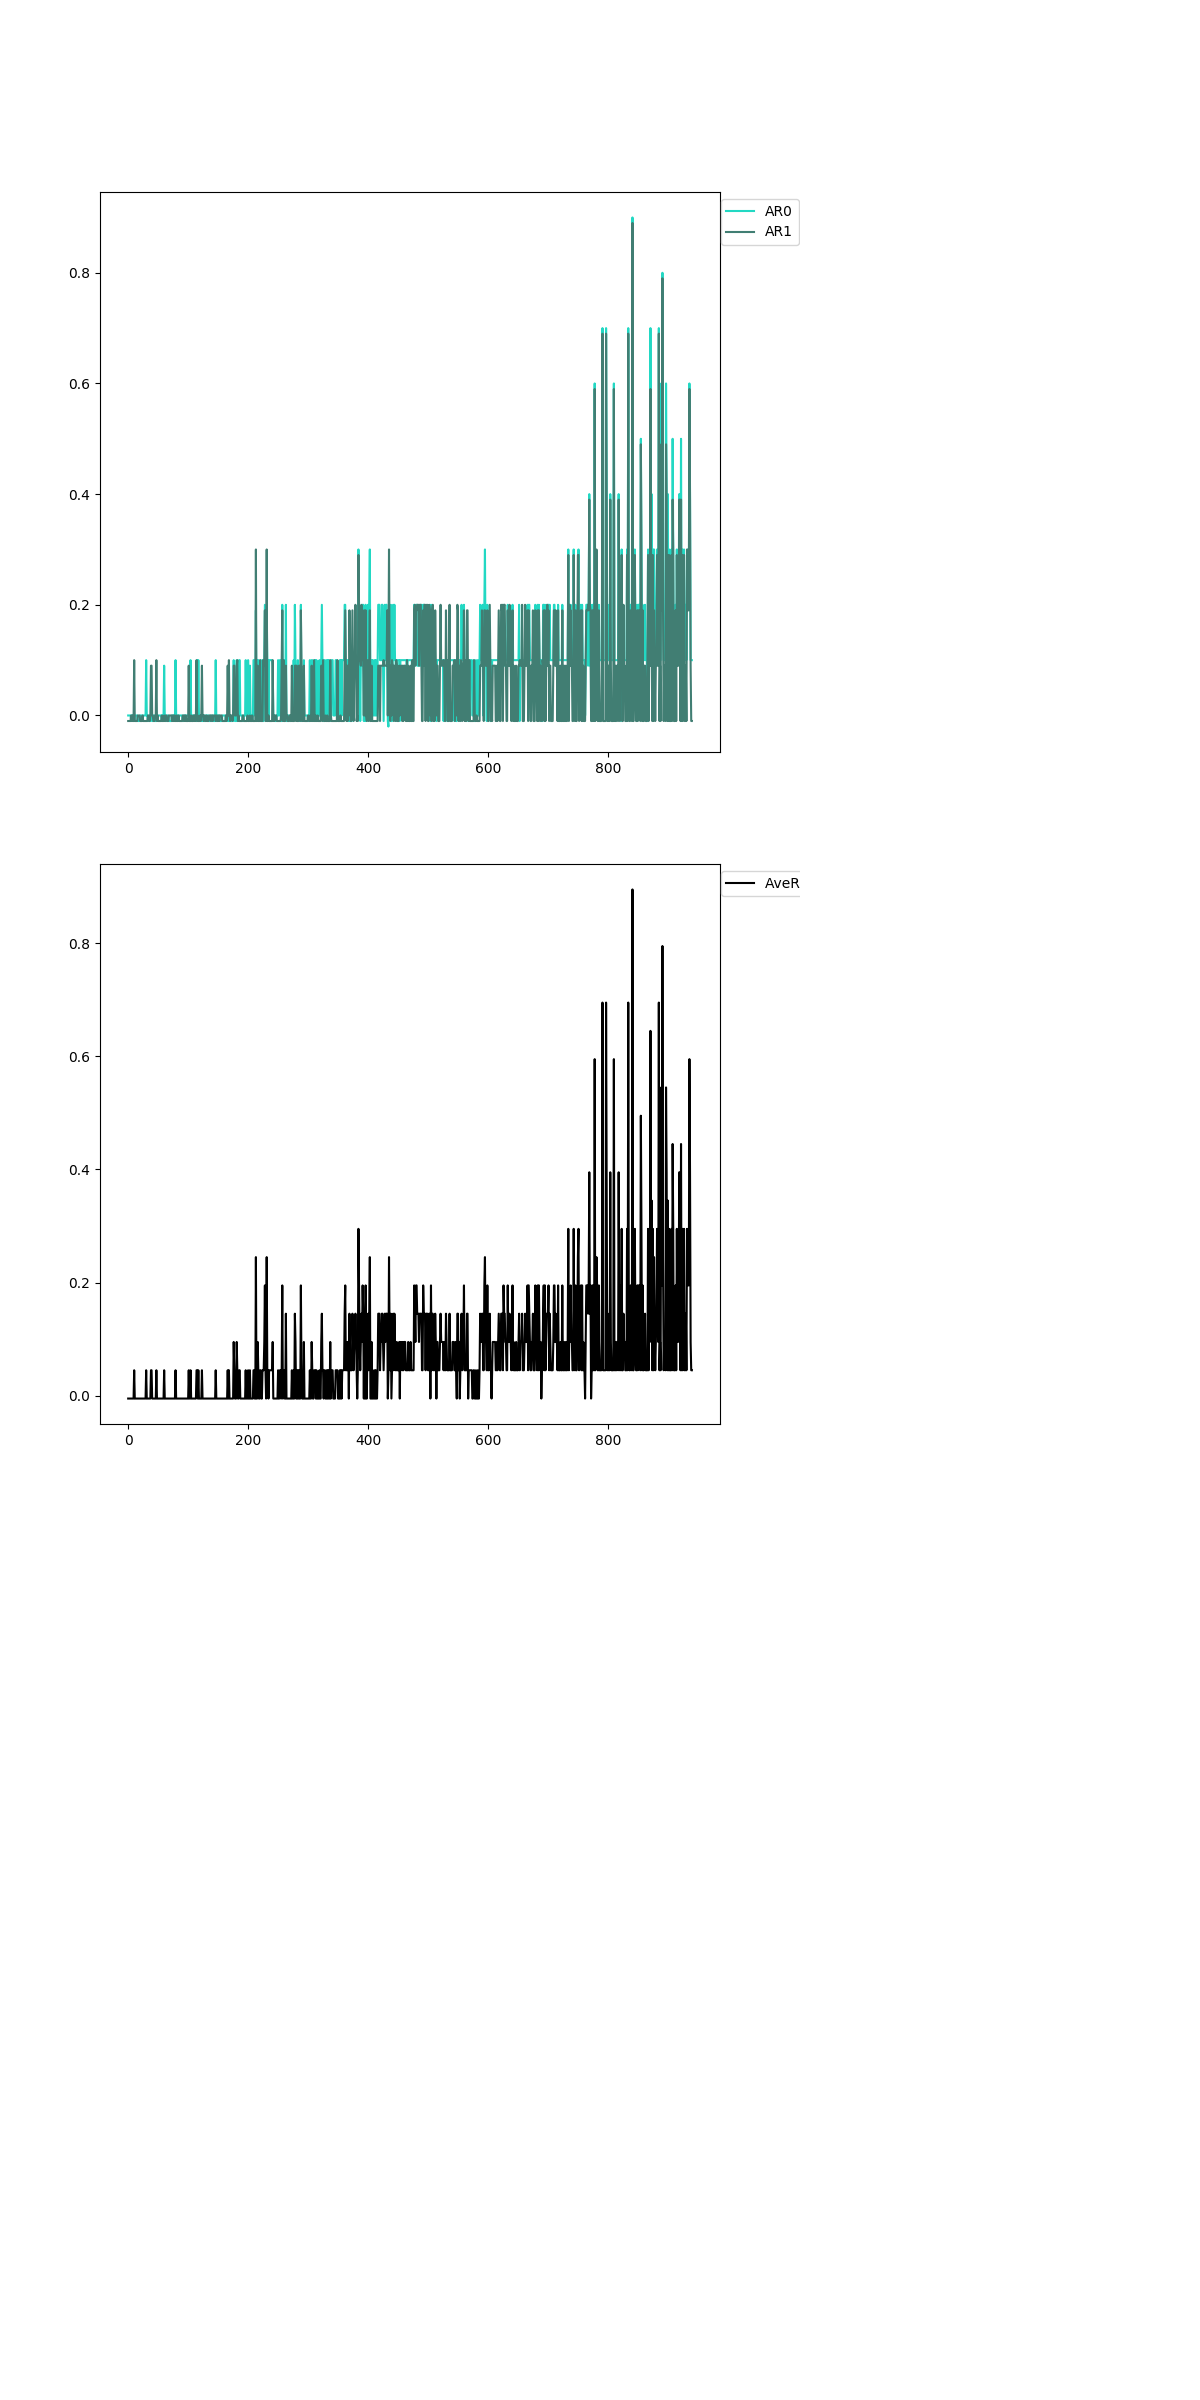

<IPython.core.display.Javascript object>


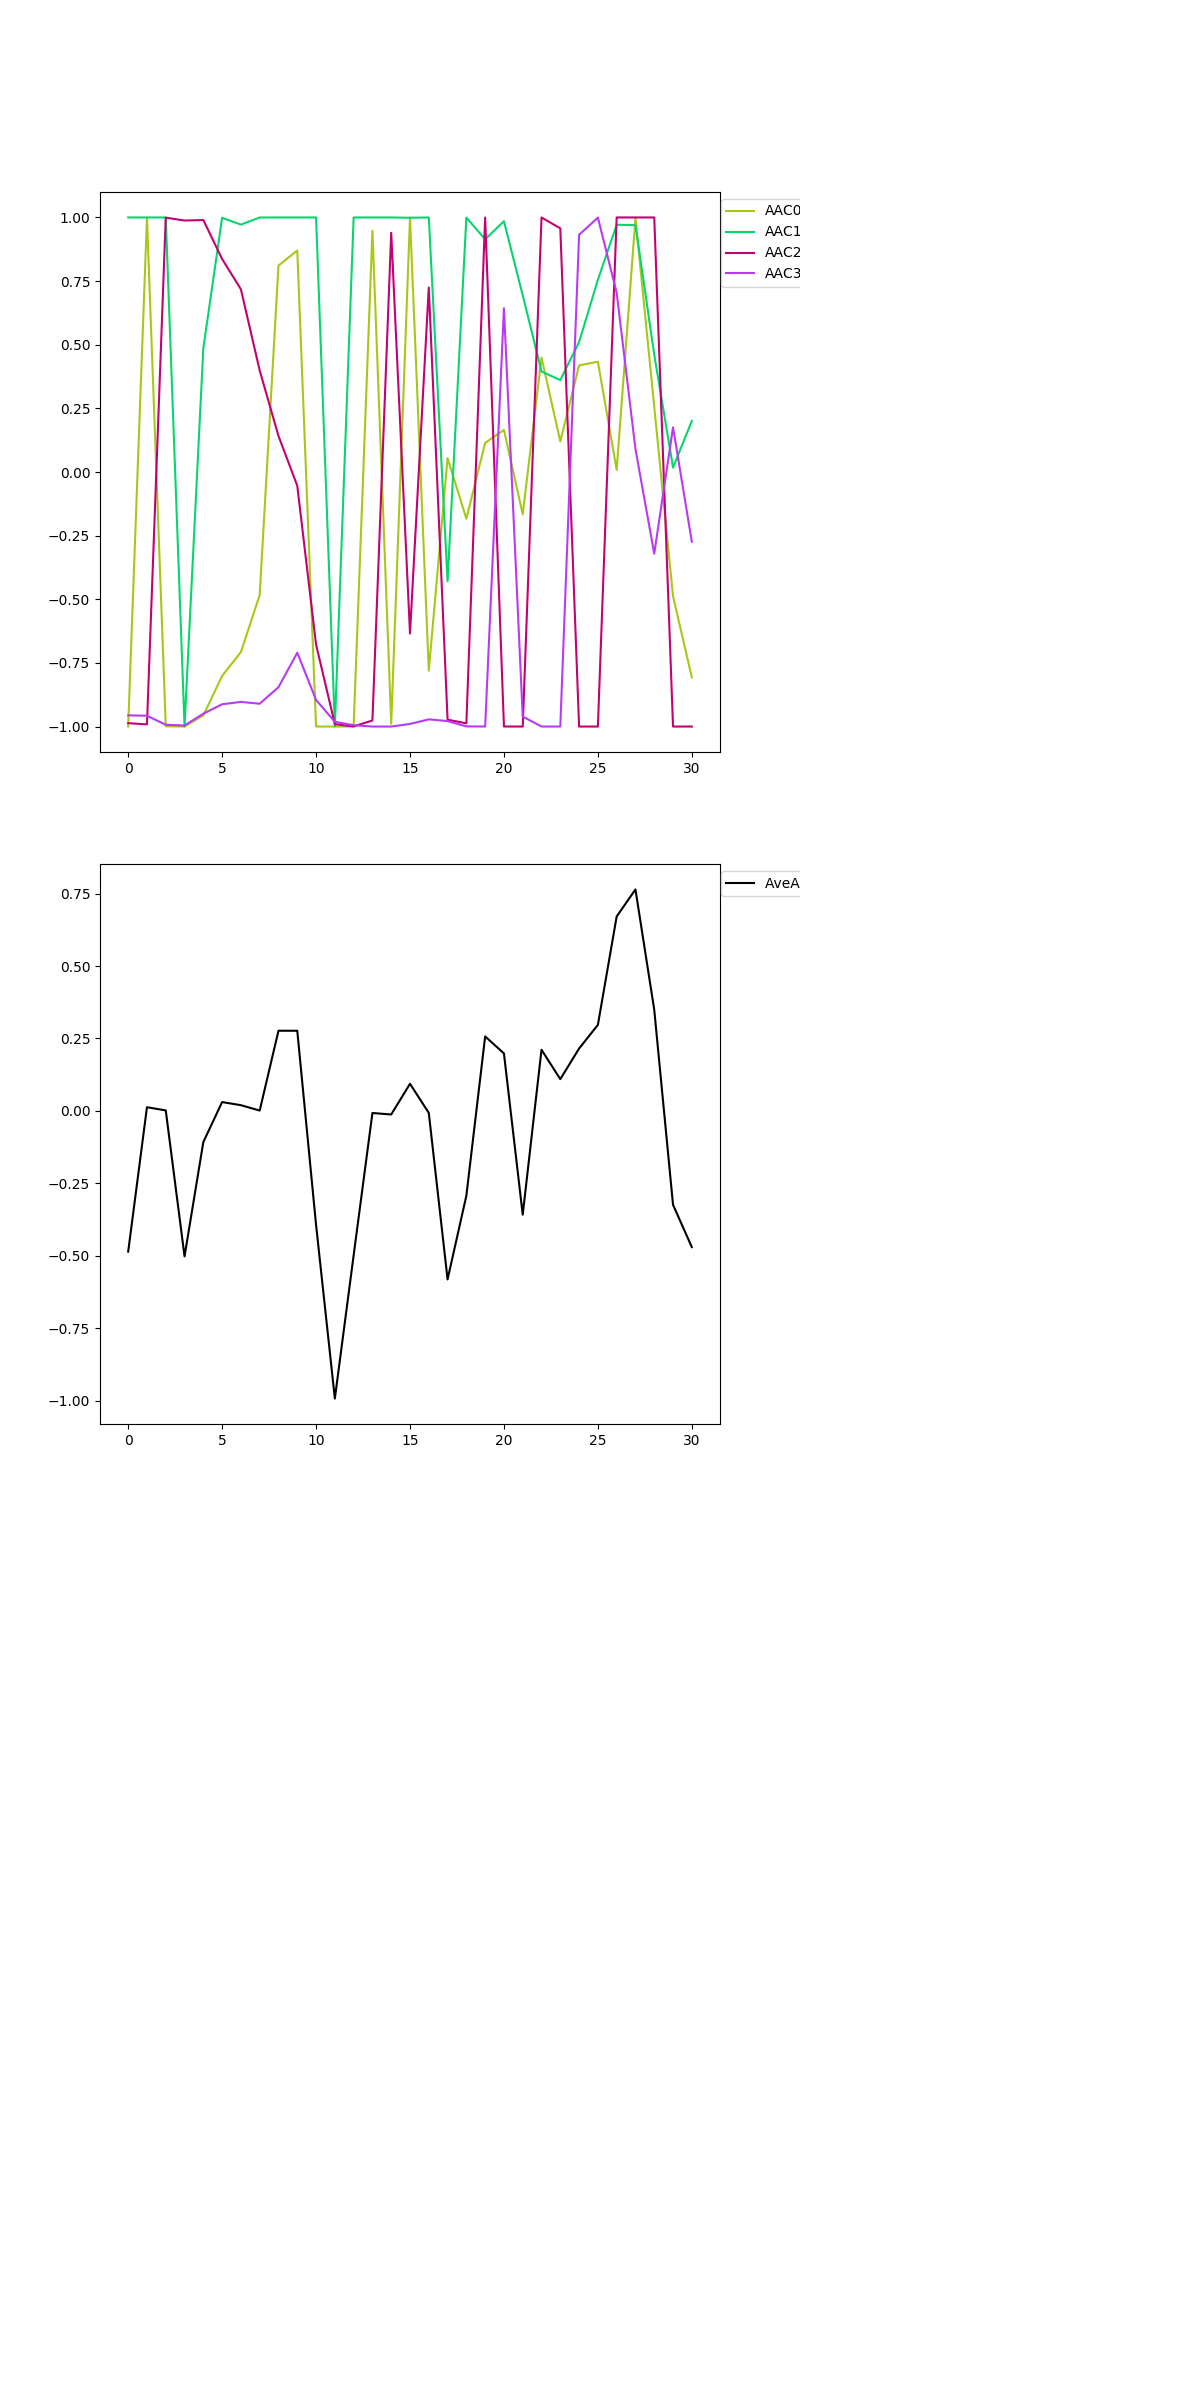

<IPython.core.display.Javascript object>


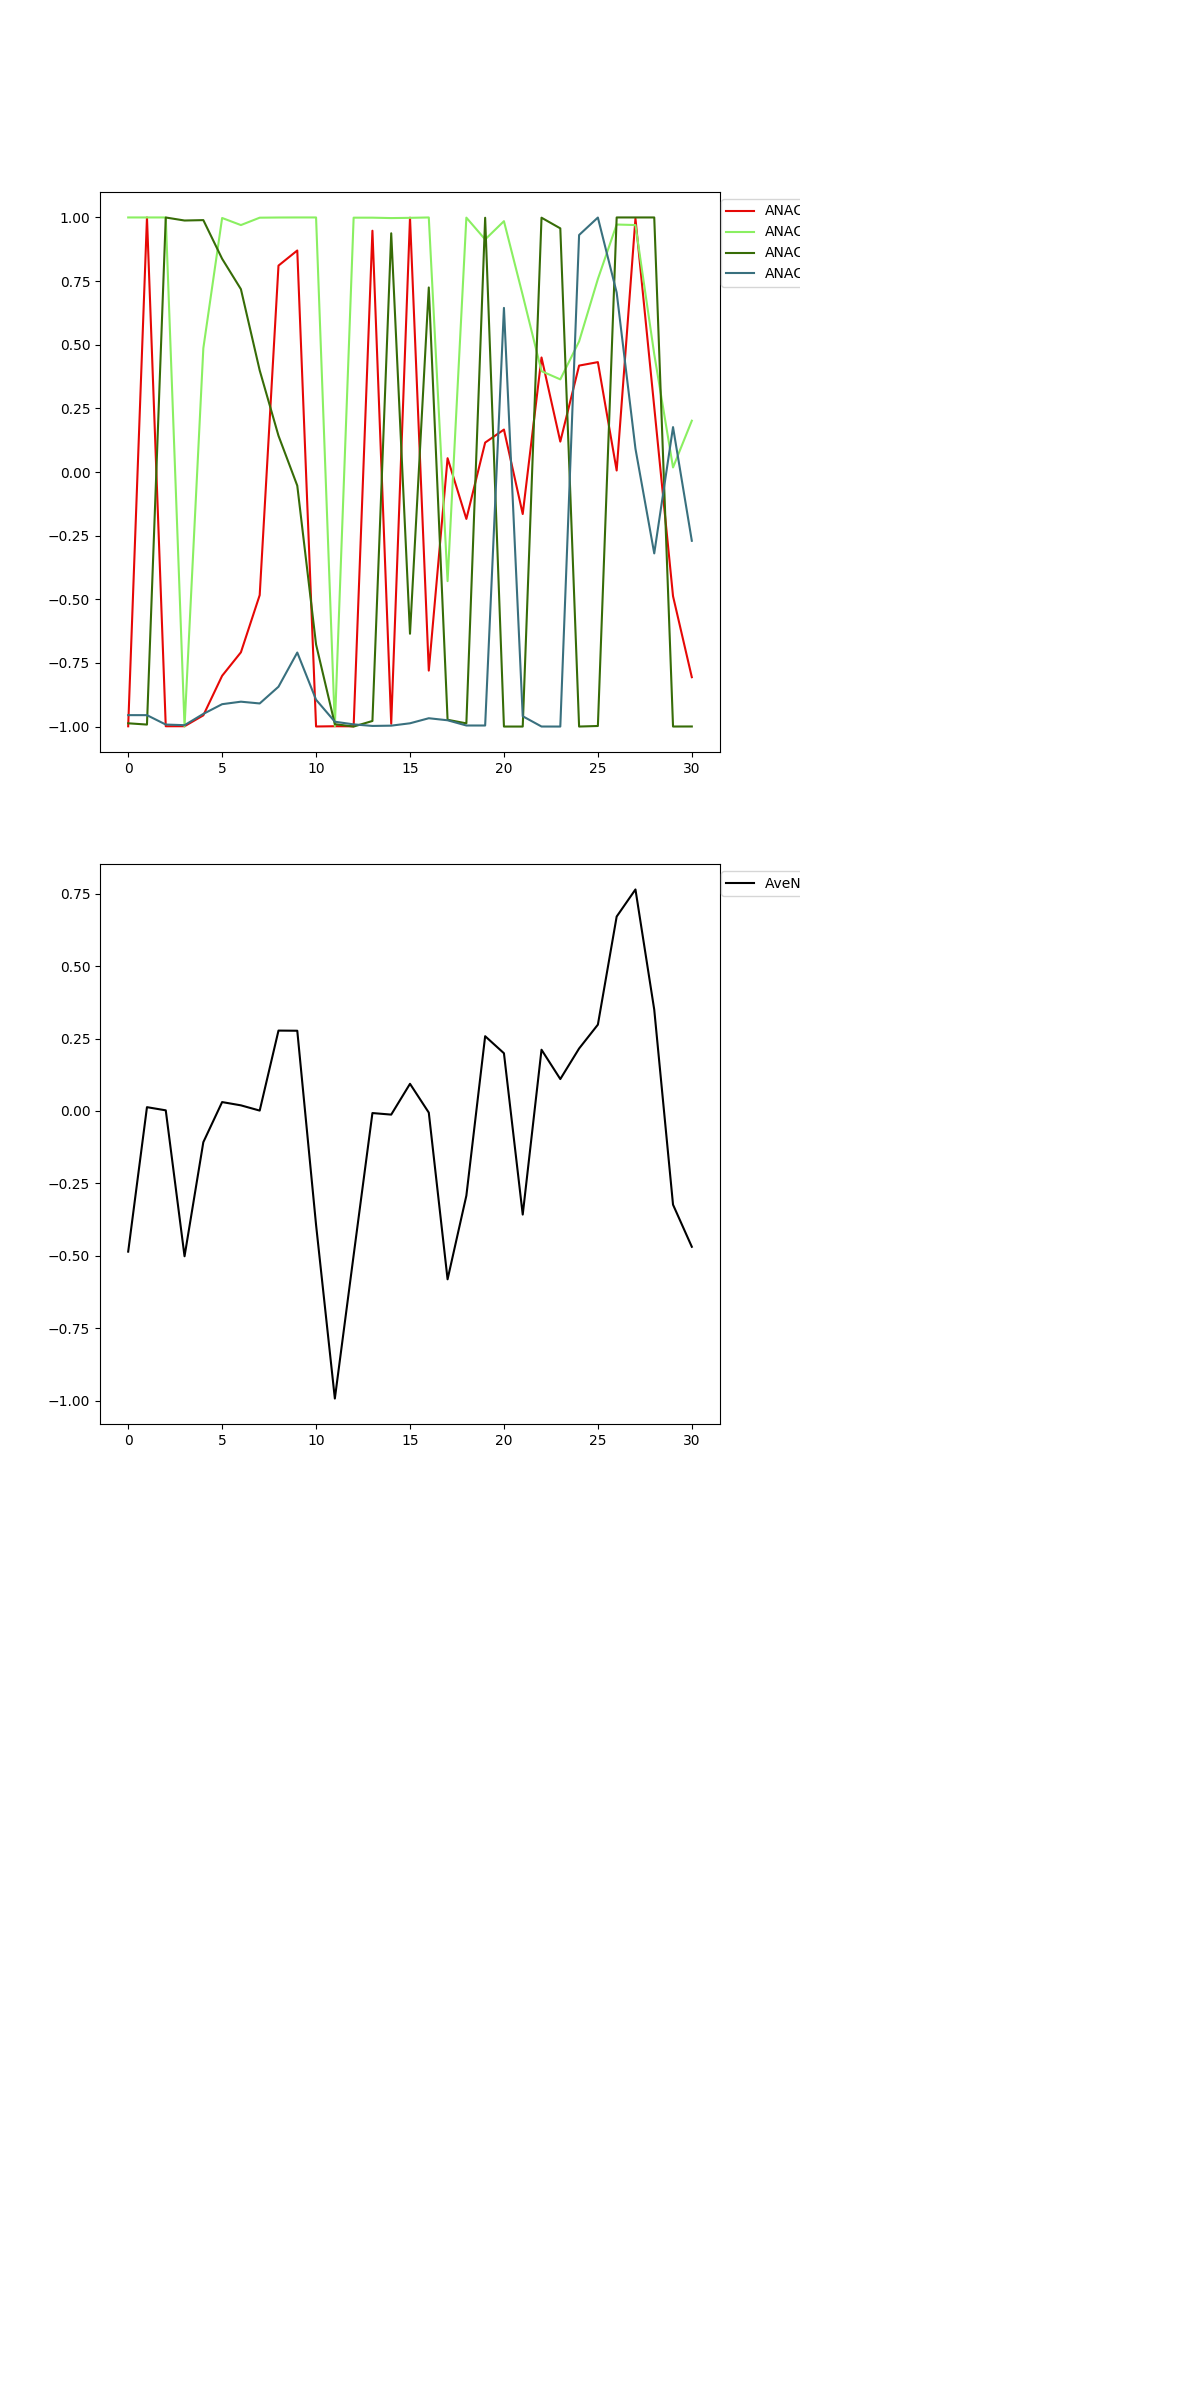

<IPython.core.display.Javascript object>


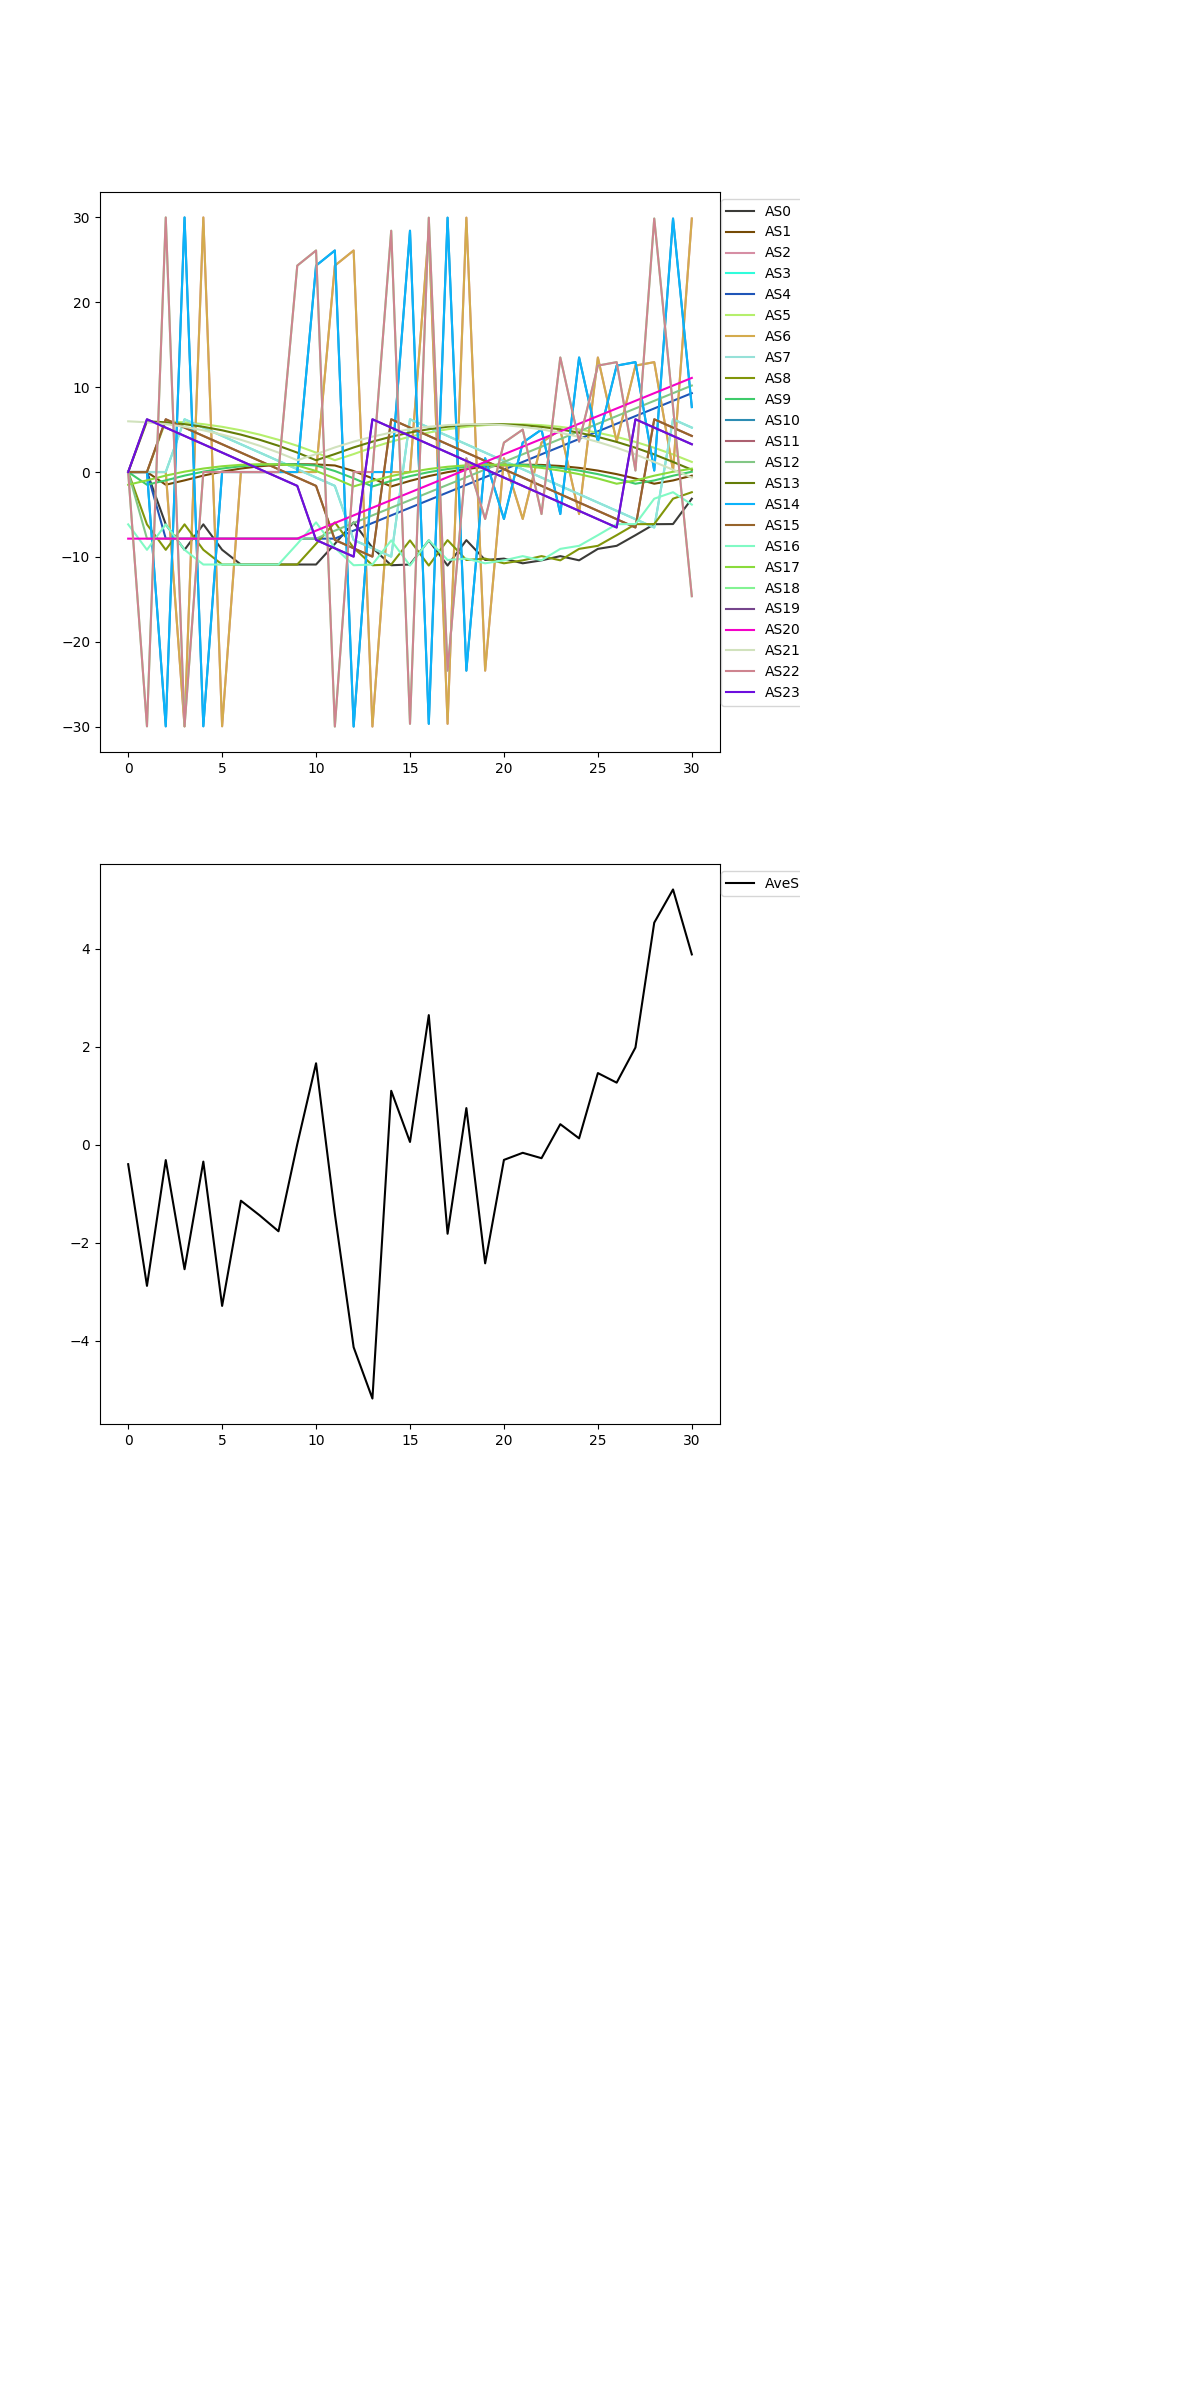

Label(value='Episode 0\tAverage Score: 0.00')

In [ ]:
def maddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    score = np.zeros(num_agents)
    
    # commenting and plotting
    desc = Label('Episode {}\tAverage Score: {:.2f}'.format(0,0))
    display(desc)
    tqm = tqdm(range(1, n_episodes+1))
    for i_episode in tqm:
        env_info    = env.reset(train_mode=True)[brain_name]
        states      = env_info.vector_observations
        for agent in agents:
            agent.reset()
        score = 0
        for t in range(max_t):
            statePlotter.push_date(states[0,:].reshape(1,state_size))
            actions = None
            for i, agent in enumerate(agents):
                actions_with_noise, actions_without_noise  = agent.act(states[i],add_noise=True)
                agent_actions = np.clip(actions_with_noise, -1, 1)
                if actions is not None:
                    actions = np.concatenate((actions,agent_actions),axis=0)
                    actions_no_noise = np.concatenate((actions_no_noise,actions_without_noise),axis=0)
                else:
                    actions = agent_actions
                    actions_no_noise = actions_without_noise
                
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            # calculate next_actions from next_states for all agents
            next_actions = None
            for i, agent in enumerate(agents):
                _, act_without_noise = agent.act(next_states[i],add_noise=False)
                if next_actions is None:
                    next_actions = act_without_noise
                else:
                    next_actions = np.vstack((next_actions, act_without_noise))
            
            for i, agent in enumerate(agents):
                agent.step(this_state            = states[i],
                           others_state          = np.delete(states, (i), axis=0).reshape(-1),
                           this_action           = actions[i],
                           others_action         = np.delete(actions, (i), axis=0).reshape(-1),
                           reward                = reward[i],
                           this_next_states      = next_states[i],
                           others_next_states    = np.delete(next_states, (i), axis=0).reshape(-1), 
                           done                  = done[i],
                          )
            
            states = next_states
            score = score + np.array(reward)
            
            actionPlotterWithoutNoise.push_date(actions_no_noise.reshape(-1))
            actionPlotter.push_date(actions.reshape(-1))
            if np.any(done):
                break 
        actionPlotter.draw(reset_for_next_time=True)
        actionPlotterWithoutNoise.draw(reset_for_next_time=True)
        statePlotter.draw(reset_for_next_time=True)
        rewardPlot.push_date(score.reshape(-1))
        rewardPlot.draw()
        scores_deque.append(score)
        scores.append(score)
        score_mean_circular = np.mean(scores_deque)
        desc.value = 'Episode {},'.format(i_episode)+ \
                     '\tMinimum Score: {:.2f},'.format(np.min(scores_deque))+ \
                     '\tAverage Score: {:.2f},'.format(score_mean_circular)
        
        
        if score_mean_circular > 0.5:
            # enough training
            for i, agent in enumerate(agents):
                agent.save_agent(f"MADDPG_agent{i}")
            
    return scores

%matplotlib notebook
rewardPlot = PlotTool(number_of_lines=num_agents, desc = "R" )
actionPlotterWithoutNoise = PlotTool(number_of_lines=action_size*2, desc = "AC")
actionPlotter = PlotTool(number_of_lines=action_size*2, desc = "NAC")
statePlotter = PlotTool(number_of_lines=state_size, desc = "S")
scores = maddpg(n_episodes=10000, max_t=10000)

env.close()